<a href="https://colab.research.google.com/github/m-aliabbas/PnuemoniaRefined/blob/master/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 30.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [3]:

from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [5]:
file_name = '/content/drive/chestXRay.zip'

In [6]:
!ls

drive  sample_data


In [7]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [8]:
unZip(file_name)

Done!


In [9]:
unZip('chest_xray.zip')

Done!


In [10]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/val/NORMAL/*.jpeg'))
# filesPos+=sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))



In [11]:
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'))
# filesNeg+=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))

In [12]:
random.shuffle(filesNeg)
len(filesPos),len(filesNeg)

(1349, 3883)

In [13]:
pos_labels=[[i,0] for i in filesPos]
neg_labels=[[i,1] for i in filesNeg]
ds=pos_labels+neg_labels

In [14]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [15]:
df

,path,label
2964,chest_xray/train/PNEUMONIA/person644_virus_122...,1
1075,chest_xray/train/NORMAL/NORMAL2-IM-1049-0001.jpeg,0
1928,chest_xray/train/PNEUMONIA/person990_bacteria_...,1
854,chest_xray/train/NORMAL/NORMAL2-IM-0774-0001.jpeg,0
1298,chest_xray/train/NORMAL/NORMAL2-IM-1323-0001.jpeg,0
...,...,...
2607,chest_xray/train/PNEUMONIA/person831_bacteria_...,1
1293,chest_xray/train/NORMAL/NORMAL2-IM-1318-0001.jpeg,0
2034,chest_xray/train/PNEUMONIA/person1625_bacteria...,1
3534,chest_xray/train/PNEUMONIA/person867_bacteria_...,1


In [16]:
dfTrain=df

In [17]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [18]:
data.classes

[0, 1]

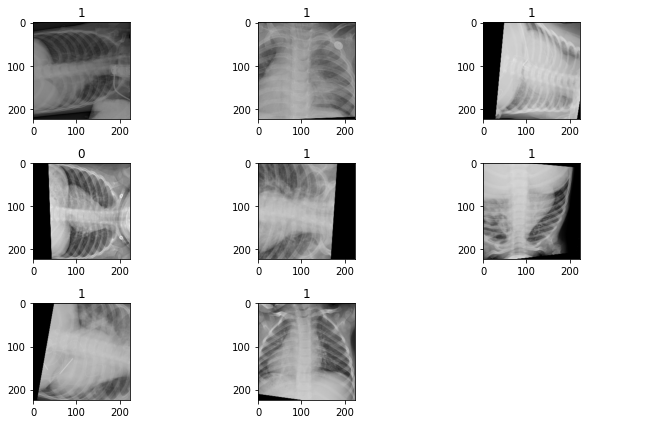

In [19]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [20]:
from sklearn.metrics import roc_auc_score,f1_score
def f1_score_a(y_pred,y_true,tens=True):
#     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
    if tens:
#         score=tensor(score)
        f1a_score=tensor(f1a_score)
    else:
        f1a_score=f1a_score
    return f1a_score


In [21]:

import torch 
import torchvision
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [22]:
num_ftrs = model.fc.in_features
model.fc=nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
    
)

In [23]:
model=model.cuda()

In [24]:
model=model.cuda()

In [25]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy],callback_fns=[partial(CSVLogger,append=True)])

In [26]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (4186 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,0,0
Path: .;

Valid: LabelList (1046 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,1,1
Path: .;

Test: None, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64

In [27]:
from fastai.callbacks import *
learn.fit(15,1e-06,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='accuracy')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.598765,0.511522,0.130019,0.869981,03:18
1,0.483409,0.378862,0.066922,0.933078,03:16
2,0.376497,0.313362,0.071702,0.928298,03:15
3,0.347366,0.255626,0.070746,0.929254,03:15
4,0.279021,0.260453,0.097514,0.902486,03:15
5,0.281479,0.206833,0.071702,0.928298,03:17
6,0.264076,0.264014,0.109943,0.890057,03:16
7,0.248484,0.206495,0.085086,0.914914,03:23
8,0.247430,0.215973,0.093690,0.906310,03:21
9,0.226551,0.212046,0.089866,0.910134,03:24


Better model found at epoch 0 with accuracy value: 0.8699808716773987.
Better model found at epoch 1 with accuracy value: 0.933078408241272.
Better model found at epoch 10 with accuracy value: 0.9349904656410217.
Better model found at epoch 13 with accuracy value: 0.9512428045272827.


In [28]:
learn.load('bestmodel');

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.160602,0.173427,0.072658,0.927342,03:25
1,0.172329,0.108339,0.042065,0.957935,03:23
2,0.147276,0.098021,0.038241,0.961759,03:21
3,0.193609,0.079465,0.027725,0.972275,03:18
4,0.085457,0.226966,0.086042,0.913958,03:20
5,0.127045,0.062345,0.024857,0.975143,03:21
6,0.089634,0.245739,0.091778,0.908222,03:21
7,0.060966,0.092392,0.035373,0.964627,03:17
8,0.048509,0.108592,0.041109,0.958891,03:15
9,0.079151,0.125987,0.048757,0.951243,03:13


/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `f1_score_a` which is not available. Available metrics are: train_loss, valid_loss, error_rate, accuracy
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


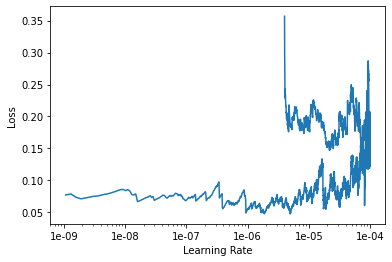

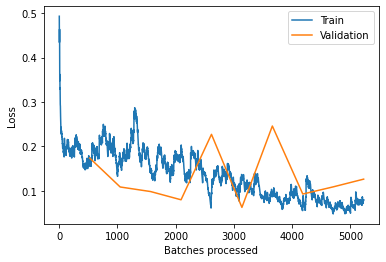

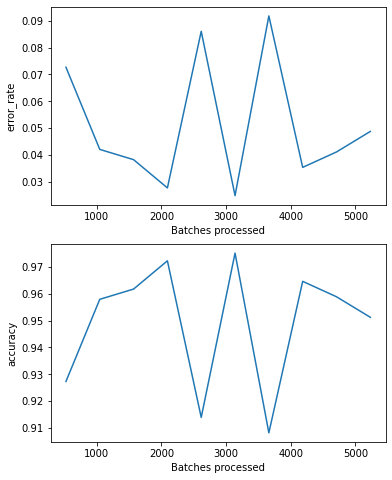

In [29]:

learn.unfreeze()
learn.fit_one_cycle(10,1e-04,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [30]:
learn.save('bestmodel')

Precision of Model = 0.9431396786155748 Recall of Model  0.9934895833333334
F1 Score of Model = 0.9676601141407736


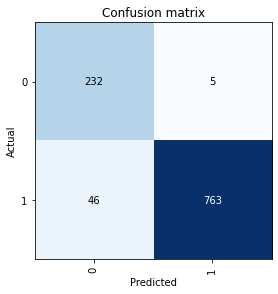

In [31]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [32]:
filesPos= sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))
filesNeg=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))

In [33]:
pos_labels=[[i,0] for i in filesPos]
neg_labels=[[i,1] for i in filesNeg]
ds=pos_labels+neg_labels

In [34]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [35]:
dfTest=df

In [36]:
dfTest

,path,label
85,chest_xray/test/NORMAL/NORMAL2-IM-0059-0001.jpeg,0
295,chest_xray/test/PNEUMONIA/person121_bacteria_5...,1
157,chest_xray/test/NORMAL/NORMAL2-IM-0281-0001.jpeg,0
165,chest_xray/test/NORMAL/NORMAL2-IM-0290-0001.jpeg,0
181,chest_xray/test/NORMAL/NORMAL2-IM-0315-0001.jpeg,0
...,...,...
559,chest_xray/test/PNEUMONIA/person78_bacteria_38...,1
269,chest_xray/test/PNEUMONIA/person111_bacteria_5...,1
462,chest_xray/test/PNEUMONIA/person1671_virus_288...,1
339,chest_xray/test/PNEUMONIA/person135_bacteria_6...,1


In [37]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
dataTest= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [38]:
learn.data.valid_dl = dataTest.train_dl

In [39]:
learn.validate()

[0.5172584, tensor(0.1891), tensor(0.8109)]

Precision of Model = 0.9948717948717949 Recall of Model  0.7607843137254902
F1 Score of Model = 0.8622222222222222


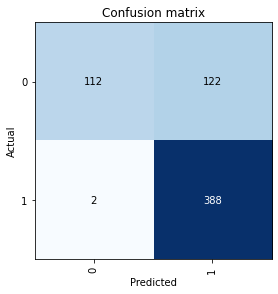

In [40]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [41]:
!ls

chest_xray  chest_xray.zip  drive  history.csv	__MACOSX  models  sample_data


In [42]:
!mkdir '/content/drive/My Drive/Res34ActualPne1'
!cp 'models/bestmodel.pth' '/content/drive/My Drive/Res34ActualPne1'
!cp 'history.csv' '/content/drive/My Drive/Res34ActualPne1'

mkdir: cannot create directory ‘/content/drive/My Drive/Res34ActualPne1’: File exists


In [84]:
from torchvision import transforms
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=224),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0],imagenet_stats[1])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=224),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0],imagenet_stats[1])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=224),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0],imagenet_stats[1])
    ])
}

In [85]:
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/val/NORMAL/*.jpeg'))
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'))


In [86]:
!rm -rf 'dataset1'

In [87]:


from fastai import *
import shutil
def copyfiles(filesName,dest):
    for file in filesName:
        shutil.copy(file, dest)
    print("done")
    
!mkdir dataset1
!mkdir dataset1/NORMAL
!mkdir dataset1/PNEUMONIA
copyfiles(filesPos,'dataset1/NORMAL')
copyfiles(filesNeg,'dataset1/PNEUMONIA')

done
done


In [88]:


 
# Batch size
bs = 4
 
# Number of classes
num_classes = 2
# Load Data from folders
data = {
    'train': torchvision.datasets.ImageFolder(root='dataset1/', transform=image_transforms['train']),
}
 
# Size of Data, to be used for calculating Average Loss and Accuracy

train_data_size = len(data['train'])

 
# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, drop_last=True,shuffle=True, num_workers=4)

 
# Print the train, validation and test set data sizes
train_data_size

5856

In [89]:
modules=list(model.children())[:-1]
featureExt=nn.Sequential(*modules)

In [90]:
feV=[]
lab=[]
for i, (inputs, labels) in enumerate(train_data):
        inputs=inputs.cuda()
        f=featureExt(inputs)
        data12=f.data
        data12=data12.cpu().data.numpy()
        labels=labels.cpu().data.numpy()
        feV+=[data12]
        for l in labels:
            lab+=[l]
        torch.cuda.empty_cache()
      
        

In [91]:
# [1][1].ravel().shape
featureList=[]
for i in range(len(feV)):
    for j in range(len(feV[i])):
        featureList+=[feV[i][j].ravel()]


In [92]:
import pandas as pd
df = pd.DataFrame(featureList)


In [93]:
df.shape
df2=pd.DataFrame(lab,columns=['labels'])

In [100]:
len(filesPos),len(filesNeg)

(1583, 4273)

In [94]:
df['label']=lab

In [95]:
df.shape

(5856, 513)

In [96]:
df.to_csv('dataset18New.csv',index=False)

In [97]:
!cp 'dataset18New.csv'  '/content/drive/My Drive/'

In [65]:
filesNeg=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))
filesPos= sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))

In [66]:

from fastai import *
import shutil
def copyfiles(filesName,dest):
    for file in filesName:
        shutil.copy(file, dest)
    print("done")
    
!mkdir dataset1
!mkdir dataset1/NORMAL
!mkdir dataset1/PNEUMONIA
copyfiles(filesPos,'dataset1/NORMAL')
copyfiles(filesNeg,'dataset1/PNEUMONIA')

done
done


In [67]:


 
# Batch size
bs = 4
 
# Number of classes
num_classes = 2
# Load Data from folders
data = {
    'train': torchvision.datasets.ImageFolder(root='dataset1/', transform=image_transforms['train']),
}
 
# Size of Data, to be used for calculating Average Loss and Accuracy

train_data_size = len(data['train'])

 
# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, drop_last=True,shuffle=True, num_workers=4)

 
# Print the train, validation and test set data sizes
train_data_size

624

In [68]:
modules=list(model.children())[:-1]
featureExt=nn.Sequential(*modules)

In [69]:
feV=[]
lab=[]
for i, (inputs, labels) in enumerate(train_data):
        inputs=inputs.cuda()
        f=featureExt(inputs)
        data12=f.data
        data12=data12.cpu().data.numpy()
        labels=labels.cpu().data.numpy()
        feV+=[data12]
        for l in labels:
            lab+=[l]
        torch.cuda.empty_cache()
      
        

In [70]:
# [1][1].ravel().shape
featureList=[]
for i in range(len(feV)):
    for j in range(len(feV[i])):
        featureList+=[feV[i][j].ravel()]


In [71]:
import pandas as pd
df = pd.DataFrame(featureList)


In [72]:
df.shape
df2=pd.DataFrame(lab,columns=['labels'])

In [73]:
df['label']=lab

In [74]:
df.shape

(624, 513)

In [75]:
df.to_csv('dataset18NewTest.csv',index=False)

In [76]:
!cp 'dataset18NewTest.csv'  '/content/drive/My Drive/'

In [79]:
!ls  '/content/drive/My Drive/' | grep 'dataset'

covid-chestxray-dataset
dataset18New.csv
dataset18NewTest.csv
dataset34New.csv
dataset34NewTest.csv
datasetCombinedRes18O.csv
datasetCombinedRes34Bal.csv
datasetCombinedRes34.csv
datasetCombinedRes34O.csv
datasetNIHRes18.csv
datasetNIHRes34.csv
Hybrid Algorithms multiple datasets-converted.gdoc
Hybrid Algorithms multiple datasets.gdoc
Hybrid Algorithms multiple datasets.pdf
